Risk dice strategy with hacker statistics 
by Govert Verberg


In the board game Risk, battled between players are simulated using dice. The most common situation is that the attacker throws with three dice, and the defender with one or two dice. The official rules can be found online. A common house rule is that the defender can choose to throw 1 or 2 dice, after the attacker throws his dice, instead of in advance. This gives the defender some extra advantage, assuming he chooses wisely. In this notebook I will calculate what the optimal strategy is for the defender in the general case, when both the attacker and the defender have a lot of armies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# create an array of the possible dice throws for the attacker
# the column number is the highest dice, the row number the lowest
# top left is 1-1 and the bottom right is 6-6, this structure will be used for all arrays

a_dice = np.zeros((6,6))
for i in range(6):
    for j in range(i+1):
        a_dice[i,j] = 1

#calculate the odds to beat the attackers dice with one dice
d_one = np.copy(a_dice)

for i,j in np.ndindex(d_one.shape):
    if d_one[i,j]:
        d_one[i,j] = (1/6) * (6-i)
        
print(a_dice)
print(d_one)

[[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]]
[[1.         0.         0.         0.         0.         0.        ]
 [0.83333333 0.83333333 0.         0.         0.         0.        ]
 [0.66666667 0.66666667 0.66666667 0.         0.         0.        ]
 [0.5        0.5        0.5        0.5        0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.        ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]


When the defender throws with 2 dice, there are 3 possible outcomes. The attacker loses 2 armies, the defender loses 2 armies or they each lose one soldier. So two armies always die. We can add the odds of all outcomes together and divide by 2 to get the chance that the defender kills an army, so it is on the same scale as the odds for one dice.

It is possible to calculate the odds to beat 2 dice analytically, but using hacker statistics is easier.

In [2]:
def rand_def():
    d_1 = np.random.randint(0,6)
    d_2 = np.random.randint(0,6)
    if d_1 < d_2:
            d_1, d_2 = d_2, d_1
    return d_1,d_2

def rand_atk():
    dice = np.random.randint(0,6,size=3)
    dice = np.sort(dice)
    return dice[-1],dice[-2]

def two_die_odds(a_1,a_2, n_iter=10000):
    """Calculate the chance for the defender to beat the given dice"""
    
    result = np.zeros(n_iter)
    
    for i in range(n_iter):
        d_1, d_2 = rand_def()
        result[i] = (d_1 >= a_1) + (d_2 >= a_2)
        
    return np.mean(result) / 2
        

In [3]:
# now create a table with the the results for every possibility

d_two = np.copy(a_dice)

for i,j in np.ndindex(d_two.shape):
    if d_two[i,j]:
        d_two[i,j] = two_die_odds(i,j)

In [4]:
print(d_two)

[[1.      0.      0.      0.      0.      0.     ]
 [0.98495 0.83275 0.      0.      0.      0.     ]
 [0.9484  0.7875  0.66665 0.      0.      0.     ]
 [0.8763  0.72585 0.59205 0.5021  0.      0.     ]
 [0.77605 0.63645 0.49945 0.40425 0.3367  0.     ]
 [0.6519  0.49535 0.37535 0.28315 0.20705 0.166  ]]


Comparing the results for throwing one dice and throwing two dice, the odds improve in favor of the defender, though for 5-5 and 6-6 it is very close and the hacker statistics do not give a definite result either way. However, throwing with 2 dice also increases the stakes, since two armies can be lost instead of one. So throwing with two dice is not always better. Where exactly is the barrier? Again we can use hacker statistics to find out.

There are 21 possible dice combinations for the attacker, so there are 21^2 possible strategies for the defender, since for each attacker throw they can throw with one or with two dice. However, most of these possible strategies do not make sense. Why throw with two dice for 4-4, but with one dice for 4-3? 

It is possible to reduce the number of possible strategies back to 21, by ranking the attacker's throws by the chance to beat them with two dice and defining the strategy as a position in the list, where the defender throws with 1 dice for every possibility ranked above that position, and with 2 dice for all others.

We can use hacker statistics to calculate the ratio of armies destroyed versus lost for each strategy, to find the optimal strategy.

In [5]:
# Create the ordered array, and add which combination of dice belongs to those odds.
# 5-5 is the combination with the lowest odds, these are array indices and represent the dice throw 6-6.

odds_vert = np.reshape(d_two,(36,1))
odds_vert = np.hstack( (odds_vert, np.zeros( (36,2) )) )

for i in range(6):
    for j in range(i+1):
        odds_vert[i*6 + j,1] = i
        odds_vert[i*6 + j,2] = j
odds_vert = odds_vert[odds_vert[:,0] != 0]    
odds_vert = odds_vert[np.argsort(odds_vert[:,0])]
print(odds_vert)

[[0.166   5.      5.     ]
 [0.20705 5.      4.     ]
 [0.28315 5.      3.     ]
 [0.3367  4.      4.     ]
 [0.37535 5.      2.     ]
 [0.40425 4.      3.     ]
 [0.49535 5.      1.     ]
 [0.49945 4.      2.     ]
 [0.5021  3.      3.     ]
 [0.59205 3.      2.     ]
 [0.63645 4.      1.     ]
 [0.6519  5.      0.     ]
 [0.66665 2.      2.     ]
 [0.72585 3.      1.     ]
 [0.77605 4.      0.     ]
 [0.7875  2.      1.     ]
 [0.83275 1.      1.     ]
 [0.8763  3.      0.     ]
 [0.9484  2.      0.     ]
 [0.98495 1.      0.     ]
 [1.      0.      0.     ]]


In [6]:
strategy = np.copy(a_dice)
print(strategy)

# This function uses hacker statistics to simulate the outcome of a particular strategy

def play_strat(strat, n_iter=20000):
    killed = 0
    lost = 0
    for i in range(n_iter):
        a_1,a_2 = rand_atk()
        if strat[a_1,a_2] == 1:
            killed += d_two[a_1,a_2] * 2
            lost += 2 - d_two[a_1,a_2] * 2
        else: 
            killed += d_one[a_1,a_2]
            lost += 1 - d_one[a_1,a_2]
    return killed/lost
        
            

[[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]]


In [7]:
# loop over different strategies
outcomes = np.zeros( (21,3) )
current_strat = strategy

for i in range(21):
    outcomes[i][0] = play_strat(current_strat)
    ind1 = int(odds_vert[i,1])
    ind2 = int(odds_vert[i,2])
    outcomes[i][1] = ind1
    outcomes[i][2] = ind2
    current_strat[ind1, ind2] = 0

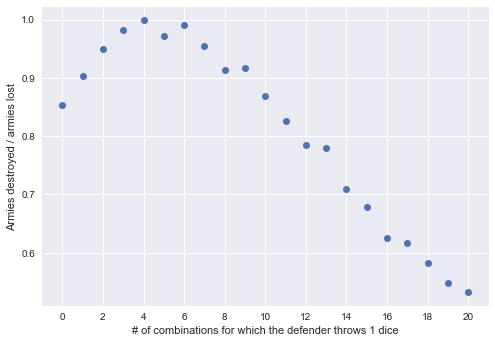

In [8]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
_ = ax.plot(outcomes[:,0], linestyle='', marker='o')
_ = ax.set_xticks(np.arange(0, 21, step=2))
_ = ax.set_xlabel('# of combinations for which the defender throws 1 dice')
_ = ax.set_ylabel('Armies destroyed / armies lost')

In [9]:
print(outcomes[outcomes[:,0] == np.max(outcomes[:,0])])
d1,d2 = outcomes[outcomes[:,0] == np.max(outcomes[:,0])][0][1:]
d1 = int(d1)
d2 = int(d2)
border = d_two[d1,d2]

[[0.9985476 5.        2.       ]]


Hacker statistics don't give deterministic outcomes, when I ran the code I got 6-3 (indices 5-2) as the boundary to still throw with two dice. Let's make a table that shows the best strategy for easy reference:

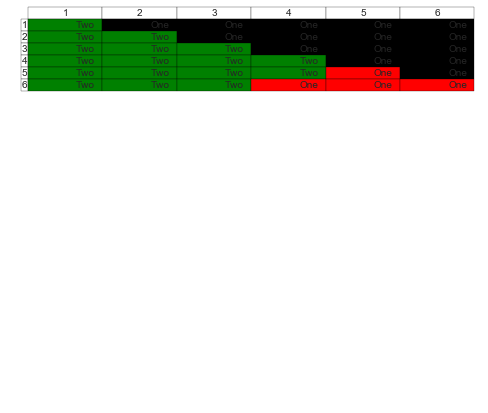

In [10]:
throw_2 = d_two >= border
table_text = []
table_color = []
row_labels = []

for i in range(6):
    
    text_row = []
    color_row = []
    
    for j in range(6):
    
        if throw_2[i,j]:
            text_row.append('Two')
            color_row.append('Green')
        elif i >= j:
            text_row.append('One')
            color_row.append('Red')
        else:
            text_row.append('One')
            color_row.append('Black')
            
    row_labels.append(str(i+1))
    table_text.append(text_row)
    table_color.append(color_row)

fig2, ax2 = plt.subplots(frameon=False)
_ = ax2.axis('off')
_ = ax2.table(cellText=table_text, cellColours=table_color,loc='top', colLabels=row_labels, rowLabels=row_labels)
            